[GoogLeNet architecture](http://arxiv.org/abs/1409.4842)

Loaded from a ProtoBuf

In [1]:
import os

import numpy as np

import tensorflow as tf

print tf.__version__

1.3.0


In [4]:
PARAMS_PATH = ''
PARAMS_FILE = PARAMS_PATH + 'inception_v3_2016_08_28_frozen.pb'

LOG_PATH = ''
LOG_DIRECTORY = LOG_PATH + 'Tensorflow/model-inceptionv3/logs'
if not os.path.exists(LOG_DIRECTORY):
    os.makedirs(LOG_DIRECTORY)

In [5]:
# creating TensorFlow session and loading the model
graph = tf.Graph()

sess = tf.InteractiveSession(graph=graph)


with tf.gfile.FastGFile(PARAMS_FILE, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())



# image_input = tf.placeholder(tf.float32, name='input') # define the input tensor
image_input = tf.placeholder(dtype=tf.float32, shape=[None, 299, 299, 3], name='input')


with tf.variable_scope('preprocess'):
    # https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py
    # Move from RGB to BGR
    image_channels = tf.unstack(image_input, axis=-1)
    image = tf.stack([image_channels[2], image_channels[1], image_channels[0]], axis=-1)    
    # Standardise.
    image = tf.divide(image, 255)
    image = tf.subtract(image, 0.5)
    image = tf.multiply(image, 2)
    # https://www.tensorflow.org/api_docs/python/tf/expand_dims
    # image_preprocessed = tf.expand_dims(image, 0)


tf.import_graph_def(graph_def, { 'input':image })

In [6]:
layers = [ op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name ]
feature_nums = [ int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers ]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

('Number of layers', 95)
('Total number of feature channels:', 18217)


In [7]:
print layers[:5]

[u'import/InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution', u'import/InceptionV3/InceptionV3/Conv2d_2a_3x3/convolution', u'import/InceptionV3/InceptionV3/Conv2d_2b_3x3/convolution', u'import/InceptionV3/InceptionV3/Conv2d_3b_1x1/convolution', u'import/InceptionV3/InceptionV3/Conv2d_4a_3x3/convolution']


In [8]:
conv = graph.get_tensor_by_name("import/InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution:0")
print conv, conv.get_shape()

Tensor("import/InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution:0", shape=(?, 149, 149, 32), dtype=float32) (?, 149, 149, 32)


In [9]:
print layers[-5:]

[u'import/InceptionV3/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/convolution', u'import/InceptionV3/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/convolution', u'import/InceptionV3/InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/convolution', u'import/InceptionV3/InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/convolution', u'import/InceptionV3/Logits/Conv2d_1c_1x1/convolution']


In [10]:
conv = graph.get_tensor_by_name("import/InceptionV3/Logits/Conv2d_1c_1x1/convolution:0")
print conv, conv.get_shape()

Tensor("import/InceptionV3/Logits/Conv2d_1c_1x1/convolution:0", shape=(?, 1, 1, 1001), dtype=float32) (?, 1, 1, 1001)


In [11]:
writer = tf.summary.FileWriter(logdir=LOG_DIRECTORY, graph=sess.graph)

print 'Run this on the command line: `tensorboard --logdir={}`'.format(LOG_DIRECTORY)

Run this on the command line: `tensorboard --logdir=Tensorflow/model-inceptionv3/logs`


---
### Testing using images

In [12]:
import scipy.misc
image = scipy.misc.imread('../images/goldfish.jpg')

print image.shape

(600, 897, 3)


In [13]:
image_resized = scipy.misc.imresize(image, [299,299])

print image_resized.shape

(299, 299, 3)


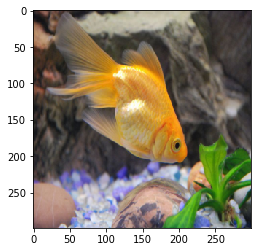

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(image_resized)

In [15]:
print graph.get_tensor_by_name("import/InceptionV3/Logits/SpatialSqueeze:0").get_shape()
print graph.get_tensor_by_name("import/InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0").get_shape()

(?, 1001)
(?, 1, 1, 1001)


In [16]:
# x = sess.run( 
#     graph.get_tensor_by_name("import/InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0"), 
#     feed_dict={ image_input: image_resized.reshape((-1,299,299,3)) } )

# print x.shape

In [17]:
# x = sess.run( 
#     graph.get_tensor_by_name("import/InceptionV3/Logits/SpatialSqueeze:0"), 
#     feed_dict={ image_input: image_resized.reshape((-1,299,299,3)) } )

# print x.shape

In [18]:
# sess.run(input.assign(image_resized))
probs = sess.run( 
    graph.get_tensor_by_name("import/InceptionV3/Predictions/Reshape_1:0"), 
    feed_dict={ image_input: image_resized.reshape((-1,299,299,3)) } )

print probs.shape

(1, 1001)


In [19]:
import pandas as pd

with open('../labels/imagenet-labels-1001.txt') as file:
    labels = file.readlines()
labels = [ x.strip() for x in labels ] 

print len(labels)

df = pd.DataFrame({ 'labels':labels, 'probabilities': probs[0,:] })
df.sort_values(by='probabilities', ascending=False).head(10)

1001


,labels,probabilities
2,goldfish,0.948336
393,rock beauty,0.002531
394,anemone fish,0.002376
408,ambulance,0.001311
974,coral reef,0.000785
65,green mamba,0.000740
89,macaw,0.000553
109,sea anemone,0.000322
988,corn,0.000296
1,tench,0.000291
